# Practice: Specific Neural Architectures for NLP

**_Yuriy Guts_**

_UCU NLP Summer School, 2018_

Based on a tutorial by Sean Robertson (<https://github.com/spro/practical-pytorch>)

## Task

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

```
> Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

> Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

## Imports

In [1]:
import glob
import math
import os
import random
import string
import time
import unicodedata

import torch.nn as nn

In [2]:
%matplotlib inline

## Prepare Dataset

Included in the `data/names` directory are 18 text files named like `[Country].txt`. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per country, {country: [names ...]}.

In [3]:
data_files = glob.glob('../data/part2/names/*.txt')

In [4]:
unique_characters = string.ascii_letters + " .,;'"

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in unique_characters
    )

test_name = 'Ślusàrski'
print(test_name, '->', unicode_to_ascii(test_name))

Ślusàrski -> Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per country
examples_by_class = {}
unique_classes = []

def read_country_names(filename):
    with open(filename, encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

for filename in data_files:
    country = os.path.splitext(os.path.basename(filename))[0]
    unique_classes.append(country)
    names = read_country_names(filename)
    examples_by_class[country] = names

In [6]:
unique_characters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [7]:
unique_classes

['Czech',
 'German',
 'Arabic',
 'Japanese',
 'Chinese',
 'Vietnamese',
 'Russian',
 'French',
 'Irish',
 'English',
 'Spanish',
 'Greek',
 'Italian',
 'Portuguese',
 'Scottish',
 'Dutch',
 'Korean',
 'Polish']

Now we have ``examples_by_class``, a dictionary mapping each class
(country) to a list of words (names).




In [8]:
print(examples_by_class['Polish'][:5])

['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']


## Encode Dataset

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size `<1 x len(unique_characters)>`. A one-hot vector is filled with 0-s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>.`

To make a word we join a bunch of those into a 2D matrix `<word_length x 1 x len(unique_characters)>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [9]:
import torch

In [10]:
character_to_index = dict(zip(unique_characters, range(len(unique_characters))))
class_to_index = dict(zip(unique_classes, range(len(unique_classes))))
index_to_class = {v: k for k, v in class_to_index.items()}

def character_to_tensor(char):
    tensor = torch.zeros(1, len(unique_characters))
    tensor[0][character_to_index[char]] = 1
    return tensor

def word_to_tensor(word):
    tensor = torch.zeros(len(word), 1, len(unique_characters))
    for i, char in enumerate(word):
        tensor[i][0][character_to_index[char]] = 1
    return tensor

def class_to_tensor(cls):
    return torch.tensor([class_to_index[cls]], dtype=torch.long)

In [11]:
print(character_to_tensor('B'))
print(character_to_tensor('B').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([1, 57])


In [12]:
print(word_to_tensor('Bishop').size())

torch.Size([6, 1, 57])


In [13]:
print(class_to_tensor('English'))

tensor([ 9])


## Create Neural Network

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
n_hidden = 128
rnn = RNN(len(unique_characters), n_hidden, len(unique_classes))

loss_func = nn.NLLLoss()
learning_rate = 0.005

To run a step of this network we need to pass an input (in our case, the
Tensor for the current character) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each country) and a next hidden state (which we keep for the next
step).

In [16]:
input = character_to_tensor('B')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use `word_to_tensor`` instead of
``character_to_tensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.

In [17]:
input = word_to_tensor('Bishop')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output.size())

torch.Size([1, 18])


As you can see the output is a ``<1 x len(unique_classes)>`` Tensor, where
every item is the likelihood of that category (higher is more likely).

In [18]:
def get_random_training_sample():
    cls = random.choice(unique_classes)
    word = random.choice(examples_by_class[cls])
    word_tensor = word_to_tensor(word)
    class_tensor = class_to_tensor(cls)
    return word, cls, word_tensor, class_tensor

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and keep hidden state for next letter
-  Compare final output to target
-  Back-propagate
-  Return the output and loss

In [19]:
def train_iter(word_tensor, class_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    
    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)

    loss = loss_func(output, class_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [20]:
def nn_output_to_class_label(output):
    top_n, top_i = output.topk(1)
    class_index = top_i[0].item()
    return index_to_class[class_index], class_index

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [21]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    word, cls, word_tensor, class_tensor = get_random_training_sample()
    output, loss = train_iter(word_tensor, class_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = nn_output_to_class_label(output)
        correct = '✓' if guess == cls else '✗ (%s)' % cls
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, word, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 0.7421 Paraskevopoulos / Greek ✓
10000 10% (0m 11s) 2.5039 Aller / German ✗ (Dutch)
15000 15% (0m 16s) 2.6536 Novy Novy / Russian ✗ (Czech)
20000 20% (0m 21s) 0.6788 Kotsilimbas / Greek ✓
25000 25% (0m 26s) 0.5732 Petri / Italian ✓
30000 30% (0m 31s) 0.7971 Gwozdek / Polish ✓
35000 35% (0m 36s) 2.5664 Broz / Spanish ✗ (Polish)
40000 40% (0m 41s) 1.6922 Mata / Spanish ✓
45000 45% (0m 46s) 0.9504 Ellery / English ✓
50000 50% (0m 51s) 0.8379 Staska / Czech ✓
55000 55% (0m 56s) 0.3232 Dreschner / German ✓
60000 60% (1m 1s) 2.3859 Hierro / Portuguese ✗ (Spanish)
65000 65% (1m 6s) 0.6600 Porra / Spanish ✓
70000 70% (1m 11s) 0.6135 Soares / Portuguese ✓
75000 75% (1m 15s) 1.1557 Faure / French ✓
80000 80% (1m 20s) 0.0174 Kozlowski / Polish ✓
85000 85% (1m 25s) 0.1971 Stroggylis / Greek ✓
90000 90% (1m 30s) 1.2789 Horton / Scottish ✗ (English)
95000 95% (1m 35s) 2.3061 Toman / Arabic ✗ (Czech)
100000 100% (1m 40s) 0.3930 Castro / Portuguese ✓


## Diagnose the Results

Plotting the historical loss from ``all_losses`` shows the network
learning:




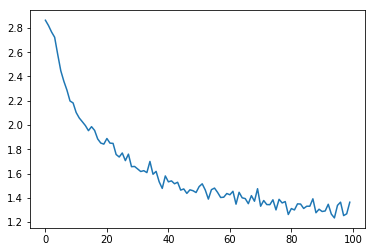

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [23]:
# Just return an output given a word tensor.
def nn_output(word_tensor):
    hidden = rnn.init_hidden()

    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)

    return output

In [24]:
def predict_top_k_classes(input_word, k=3):
    print()
    print('Predicting:', input_word)
    
    with torch.no_grad():
        output = nn_output(word_to_tensor(input_word))

        # Get top N categories
        topv, topi = output.topk(k, 1, True)
        predictions = []

        for i in range(k):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, index_to_class[category_index]))
            predictions.append([value, index_to_class[category_index]])

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``nn_output()``, which is the same as ``train()`` minus the backprop.




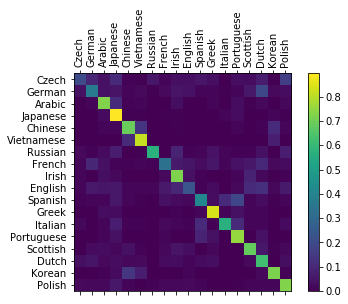

In [25]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(unique_classes), len(unique_classes))
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    word, cls, word_tensor, class_tensor = get_random_training_sample()
    output = nn_output(word_tensor)
    guess, guess_idx = nn_output_to_class_label(output)
    class_idx = class_to_index[cls]
    confusion[class_idx][guess_idx] += 1

# Normalize by dividing every row by its sum
for i in range(len(unique_classes)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + unique_classes, rotation=90)
ax.set_yticklabels([''] + unique_classes)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Try your own input!

In [26]:
predict_top_k_classes('Shevchenko')


Predicting: Shevchenko
(-0.43) Russian
(-1.47) Japanese
(-2.91) Dutch
